In [511]:
%%javascript

IPython.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : "run cell and keep focus", //This is optional
    handler : function (event) {
        IPython.notebook.execute_cell();
        IPython.notebook.edit_mode();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [512]:
import torch

In [513]:
cd ~/pytorch-classification/

/home/amir/pytorch-classification


# Slicing a filter along different dimensions.


In [514]:
import os
%pylab inline
import pandas as pd
# Let's try to train a fraction of the parameters.
#import os
homedir = os.path.expanduser('~')

def make_checkpoint_path(ckpt_base_dir,arch,frac,iter_,my_optimizer,subsample,kill_fixed,dataset='cifar10',train_only='train_all',
                        learn_bn=True,dim_slice=0):
    P = arch_to_name_prefix[arch]
    checkpointPath = os.path.join(ckpt_base_dir,
                                  '{f_arch}_{bb}_iter_{iter_}_opt_{opt}_subsample_{s}'.
                                  format(f_arch=P,bb=frac,iter_=iter_,opt=my_optimizer,s=subsample))
    if kill_fixed:
        checkpointPath += '_zero_fixed'
        
    #if frac >= 1:# a fixed integer amount of filters.
    #    checkpointPath += '_I'
    if dataset != 'cifar10':
        checkpointPath += '_C100'
        
    if fast_schedule:
        checkpointPath += '_FS'        
        
    if train_only!='train_all':
        checkpointPath += '_only_{}'.format(train_only)
    if not learn_bn:
        checkpointPath += '_no-bn'
    if dim_slice != 0:
        checkpointPath += '_DS_{}'.format(dim_slice)
    return checkpointPath

Populating the interactive namespace from numpy and matplotlib


In [515]:
subsample=1
TEST_subsample=1
my_optimizer='sgd'
epochs = 200
checkpointPaths = []
archs = ['densenet_partial']
datasets = ['cifar10','cifar100']
#archs = ['wrn_partial']
pp=0
verbose=False
from itertools import product
fast_schedule = False
status = []
optimizers = ['sgd']
iters = [0]
fracs =  [.1,1]

resnetWidth = 4
LIMIT_EPOCHS = -1
learn_bns = [True]
train_onlys = ['conv1','block1','block2','block3','fc','train_all']
dim_slices = [0]#,1,2,3]

fracs = [0.07,0.1,0.4,0.7,-1,1,5]
resnetWidth=10
archs = ['densenet_partial','wrn_partial','densenet','wrn','vgg19_bn_partial','alexnet_partial']
kill_fixed_s = [False,True]
#archs = ['densenet_partial']
train_onlys = ['train_all']
learn_bns = [True]


all_opts = list(product(fracs,datasets,optimizers,archs,kill_fixed_s,iters,train_onlys,learn_bns,dim_slices))
opts_with_state=[]
ddd = []
dfs = {}

DDD = '/home/amir/checkpoints/cifar10/'
#DDD = '/media/amir/f8fae5d8-7d7e-43d2-b99a-4a5f79117ac8/checkpoints/cifar10'
DDD_target = '/home/amir/checkpoints/cifar10'
ckpt_base_dir = DDD
arch_to_name_prefix = {'squeezenet1_1_partial':'SQZ-frac',\
    'vgg19_partial':'VGG-frac',\
                       'vgg19_bn_partial':'VGG-BN-frac',\
                       'alexnet_partial':'ALEXNET-frac','wrn_partial':'WRN-28-{}-frac'.format(resnetWidth),'densenet_partial':'densenet-bc-100-12'}
arch_to_params = {'alexnet_partial':dict(epochs=164,lr_sched='81 122'),
                  'squeezenet1_1_partial':dict(epochs=164,lr_sched='81 122'),
                  'vgg19_partial':dict(epochs=164,lr_sched='81 122'),
                  'vgg19_bn_partial':dict(epochs=164,lr_sched='81 122'),
                  'wrn_partial':dict(epochs=200,lr_sched='60 120 160'),
                  'densenet_partial':dict(epochs=300,lr_sched='150 225')}

arch_to_params['wrn']=arch_to_params['wrn_partial']
arch_to_params['densenet']=arch_to_params['densenet_partial']
arch_to_name_prefix['wrn']=arch_to_name_prefix['wrn_partial']
arch_to_name_prefix['densenet']=arch_to_name_prefix['densenet_partial']
#arch_to_params['wrn']=arch_to_params['wrn_partial']

import matplotlib.patches as patches
PRINT_CMD=True
covered_paths = {}

for frac,dataset,my_optimizer,arch,kill_fixed,iter_,to_train_only,learn_bn,dim_slice in all_opts:
    arch_= arch
       
    if frac == -1 and kill_fixed:
        continue
    #if frac >.1:
    #    if dim_slice not in [0,1]:
    #        continue
    n_epochs = arch_to_params[arch]['epochs']

    if fast_schedule:
        n_epochs=10

    if LIMIT_EPOCHS > 0:
        n_epochs = min(LIMIT_EPOCHS,n_epochs)            
        ckpt_base_dir = DDD + 'LIMIT_EPOCHS'
    if frac > 0 and frac * 16 < 1: # check if there are no non-zero parameters in the first layer.
        print('continuing on frac:',frac)
        continue
    
    epochs = n_epochs
    if my_optimizer.lower()=='adam':
        epochs=10
    if frac == 0 and kill_fixed:
        epochs = 1

    checkpointPath = make_checkpoint_path(ckpt_base_dir,arch,frac,iter_,my_optimizer,subsample,
                                         kill_fixed,dataset,to_train_only,learn_bn,dim_slice)                        

    checkpointPaths.append(checkpointPath)

    if 'wrn' in arch:
        cmd = 'python cifar.py -a {arch} --depth 28 --widen-factor {resnetWidth} --train-batch 128 --drop 0.3 --wd 5e-4 --gamma 0.2 --epochs {epochs}'.\
        format(resnetWidth=resnetWidth,arch=arch_,epochs=epochs)
    elif 'dense' in arch:                
        cmd = 'python cifar.py -a {arch} --depth 100 --growthRate 12 --train-batch 64 --wd 1e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs)
    elif 'alexnet' in arch:
        cmd = 'python cifar.py -a {arch} --wd 1e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs) 
    elif 'vgg' in arch:
        cmd = 'python cifar.py -a {arch} --wd 1e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs) 
    elif 'squeeze' in arch:
        cmd = 'python cifar.py -a {arch} --lr 0.04 --wd 2e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs) 
    cmd += ' --checkpoint {checkpoint}'
    #cmd += ' --only-layer {retrain_layer}'

    lr=.1 if my_optimizer == 'sgd' else 1e-3

    cmd = cmd.format(checkpoint = checkpointPath)#,retrain_layer=retrain_layer)
    cmd += ' --start-epoch 0'
    cmd += ' --learn-bn {}'.format(learn_bn)        
    cmd += ' --lr {}'.format(lr)
    cmd += ' --optimizer {}'.format(my_optimizer)
    cmd += ' --subsample {}'.format(subsample)
    cmd += ' --test-subsample {}'.format(TEST_subsample)
    cmd += ' --zero-fixed-part {}'.format(kill_fixed)
    cmd += ' --part {frac}'.format(frac=frac)            
    if fast_schedule:
        cmd += ' --schedule 4 4'
    else:
        cmd += ' --schedule {}'.format(arch_to_params[arch]['lr_sched'])


    cmd += ' --dataset {}'.format(dataset)
    
    cmd += ' --dim-slice {}'.format(dim_slice)

    if frac == -1 and to_train_only != 'train_all':
        print 'hay'
        cmd += ' --only-layer {}'.format(to_train_only)
    #cmd += ' --schedule 10 20'

    logFilePath = os.path.join(checkpointPath,'log.txt')
    if logFilePath in covered_paths:
        continue
    else:
        covered_paths[logFilePath]=1
    paramCountPath = os.path.join(checkpointPath,'n_params.txt')
    #frac,dataset,my_optimizer,arch,kill_fixed,iter_,to_train_only 
    curOpts = dict(my_optimizer=my_optimizer,arch=arch,dataset=dataset,kill_fixed=kill_fixed,frac=frac,logFilePath=logFilePath,
                  train_only=to_train_only,learn_bn=learn_bn,dim_slice=dim_slice)
    
  
    if os.path.isfile(logFilePath):
        logData = open(logFilePath).readlines()

        try:
            n_params = open(paramCountPath).readlines()
            n_params = [int(p.strip().split()[-1]) for p in n_params]
        except:
        
            n_params = [-1 -1]
            
        nRows = len(logData)
        if nRows < epochs + 1:
            curOpts['ok']=False
            curOpts['message']='not enough rows'
            if verbose:
                print 'found log file but number of rows was',nRows
                print checkpointPath                    
        elif nRows >= epochs+1:
            curOpts['ok'] = True
            curOpts['message'] = 'found.'                
            try:

                dfs[frac] = pd.read_table(logFilePath)
                curValidAcc = dfs[frac]['Valid Acc.'][:epochs].max()                   
                ddd.append(dict(frac=frac,arch=arch,dataset=dataset,fast_schedule=fast_schedule,kill_fixed=kill_fixed,
                                optimizer=my_optimizer,valid_acc=curValidAcc,all_accs=dfs[frac]['Valid Acc.'],train_only=to_train_only,
                                active_params = n_params[0],total_params=n_params[1],learn_bn=learn_bn,dim_slice=dim_slice))

            except e:
                #raise(e)
                print 'FAILED LOADING',logFilePath                
                pass        
    else:
        curOpts['ok']=False
        curOpts['message']='file not found'
        if verbose:
            print 'could not find log file for {},{},{},{},{},{}'.format(my_optimizer,arch,dataset,kill_fixed,frac_,iter_)
            print 'directory:',checkpointPath
            #break
    if not curOpts['ok']:            
        # not ok, needs to be computed. 
        PRINT_CMD=True
        #if PRINT_CMD: print(cmd.replace(DDD,DDD_target))
        if PRINT_CMD: print(cmd.replace(DDD,DDD))
        #pass
    opts_with_state.append(curOpts)

    pp+=1

print
print
import seaborn as sns
#sns.set_style('ticks')
#sns.set_context('paper',font_scale=1.5)
rn = {'valid_acc':'% Accuracy','kill_fixed':'zero_fixed'}
print 
print

In [516]:
df_state=pd.DataFrame(opts_with_state)
df_state[df_state.ok==False]

,arch,dataset,dim_slice,frac,kill_fixed,learn_bn,logFilePath,message,my_optimizer,ok,train_only


In [261]:
df.keys()

Index([u'active_params', u'all_accs', u'arch', u'dataset', u'dim_slice',
       u'fast_schedule', u'frac', u'kill_fixed', u'learn_bn', u'optimizer',
       u'total_params', u'train_only', u'valid_acc'],
      dtype='object')

In [594]:
df_max

,active_params,all_accs,arch,dataset,dim_slice,fast_schedule,frac,kill_fixed,learn_bn,optimizer,total_params,train_only,valid_acc
62,1751020,0 7.17 1 14.21 2 15.84 3 ...,alexnet,cifar100,0,False,0.7,False,True,sgd,2495396,train_all,44.79
70,20086692,0 3.49 1 6.47 2 9.85 3 ...,vgg19_bn,cifar100,0,False,-1.0,False,True,sgd,20086692,train_all,71.71
54,1727890,0 38.16 1 47.37 2 48.71 3 ...,alexnet,cifar10,0,False,0.7,False,True,sgd,2472266,train_all,75.26
68,800032,0 16.02 1 26.15 2 36.33 3 ...,densenet,cifar100,0,False,-1.0,False,True,sgd,800032,train_all,77.47
69,36536884,0 10.83 1 21.59 2 31.32 3 ...,wrn,cifar100,0,False,-1.0,False,True,sgd,36536884,train_all,81.57
66,20040522,0 11.10 1 11.65 2 25.81 3 ...,vgg19_bn,cifar10,0,False,-1.0,False,True,sgd,20040522,train_all,92.85
64,769162,0 56.76 1 68.81 2 74.09 3 ...,densenet,cifar10,0,False,-1.0,False,True,sgd,769162,train_all,95.35
65,36479194,0 52.08 1 60.38 2 62.54 3 ...,wrn,cifar10,0,False,-1.0,False,True,sgd,36479194,train_all,96.10


In [605]:
df = pd.DataFrame(ddd)
df=df[['arch','active_params','valid_acc','dataset','frac','kill_fixed','total_params']]
df = df[df.dataset=='cifar10']
df = df[(df.frac>=.4) |(df.frac<0)]
df = df[df.frac<1]
df.sort_values('valid_acc',ascending=False)

,arch,active_params,valid_acc,dataset,frac,kill_fixed,total_params
65,wrn_partial,36479194,96.10,cifar10,-1.0,False,36479194
51,wrn_partial,25542739,95.98,cifar10,0.7,True,36479194
50,wrn_partial,25542739,95.90,cifar10,0.7,False,36479194
34,wrn_partial,14606284,95.75,cifar10,0.4,False,36479194
35,wrn_partial,14606284,95.49,cifar10,0.4,True,36479194
64,densenet_partial,769162,95.35,cifar10,-1.0,False,769162
49,densenet_partial,532894,94.53,cifar10,0.7,True,769162
48,densenet_partial,532894,94.39,cifar10,0.7,False,769162
32,densenet_partial,305701,93.33,cifar10,0.4,False,769162
66,vgg19_bn_partial,20040522,92.85,cifar10,-1.0,False,20040522


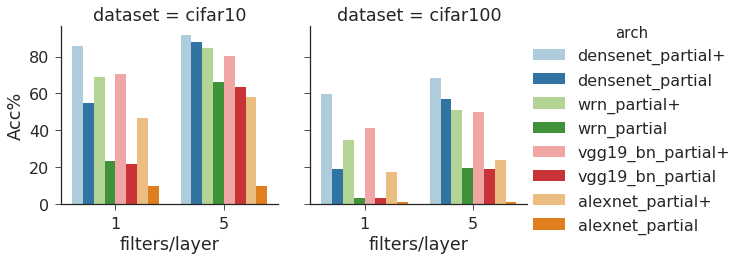

In [537]:
#42

df_max=df.loc[df.groupby('arch')['valid_acc'].idxmax()].sort_values('valid_acc')

sns.set_palette(sns.color_palette('Paired',8))
def foo(x):
    if x:
        return ''
    else:
        return '+'
df = pd.DataFrame(ddd)
df = df[(df.frac>=1) ]
df.frac=df.frac.apply(int)
#df.at[df.frac<0,'frac']=''
df=df[['arch','active_params','valid_acc','dataset','frac','kill_fixed','total_params']]
#df=df[df.dataset=='cifar10']
#df=df[['arch','valid_acc','frac','kill_fixed','dataset']]
df.arch=df.arch+df.kill_fixed.apply(foo) 
df['Acc%']=df.valid_acc
df['filters/layer']=df.frac
#df=df.sort_values('frac',ascending=True)
g=sns.factorplot(data=df,x='filters/layer',hue='arch',y='Acc%',kind= 'bar' ,col='dataset',legend_out=True)
#g.set_xticklabels(rotation=-90)

axes_ = list(g.axes[0])
savefig('/home/amir/Dropbox/publications/2018/BMVC/BMVC2018_sty_review/figures/integer_perf.pdf',bbox_inches='tight')

In [453]:
df1=df[(df.dataset=='cifar10') &(df['filters/layer']==5)].sort_values('Acc%')
df1['p_params']=100*df1.active_params/df1.total_params
df1

,arch,active_params,valid_acc,dataset,frac,kill_fixed,total_params,Acc%,filters/layer,p_params
95,alexnet_partial,49850,10.00,cifar10,5,True,2472266,10.00,5,2.016369
94,alexnet_partial+,49850,58.12,cifar10,5,False,2472266,58.12,5,2.016369
93,vgg19_bn_partial,240993,63.29,cifar10,5,True,20040522,63.29,5,1.202529
91,wrn_partial,402097,66.47,cifar10,5,True,36479194,66.47,5,1.102264
92,vgg19_bn_partial+,240993,80.38,cifar10,5,False,20040522,80.38,5,1.202529
90,wrn_partial+,402097,84.43,cifar10,5,False,36479194,84.43,5,1.102264
89,densenet_partial,177973,87.63,cifar10,5,True,769162,87.63,5,23.138559
88,densenet_partial+,177973,91.82,cifar10,5,False,769162,91.82,5,23.138559


In [593]:
df = pd.DataFrame(ddd)
df=df[['arch','active_params','valid_acc','dataset','frac','kill_fixed','total_params']]
df.sort_values('valid_acc',ascending=False)

,arch,active_params,valid_acc,dataset,frac,kill_fixed,total_params
65,wrn_partial,36479194,96.10,cifar10,-1.00,False,36479194
51,wrn_partial,25542739,95.98,cifar10,0.70,True,36479194
50,wrn_partial,25542739,95.90,cifar10,0.70,False,36479194
34,wrn_partial,14606284,95.75,cifar10,0.40,False,36479194
35,wrn_partial,14606284,95.49,cifar10,0.40,True,36479194
64,densenet_partial,769162,95.35,cifar10,-1.00,False,769162
49,densenet_partial,532894,94.53,cifar10,0.70,True,769162
48,densenet_partial,532894,94.39,cifar10,0.70,False,769162
18,wrn_partial,3669829,94.12,cifar10,0.10,False,36479194
32,densenet_partial,305701,93.33,cifar10,0.40,False,769162


In [ ]:
#df=df[['arch','dataset','valid_acc','dataset','frac','kill_fixed','total_params']]

In [398]:
baseDir

'/home/amir/Dropbox/publications/2018/BMVC/BMVC2018_sty_review/figures/'

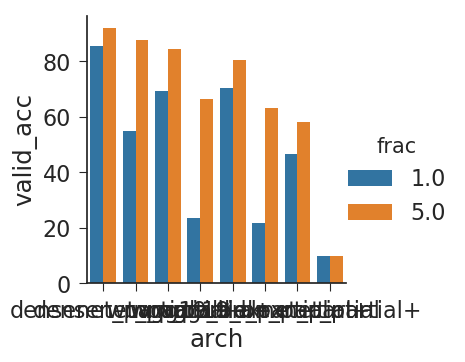

In [356]:
df.sort_values('arch')

,arch,valid_acc,frac,kill_fixed
78,alexnet_partial,46.62,1.0,False
79,alexnet_partial,10.00,1.0,True
94,alexnet_partial,58.12,5.0,False
95,alexnet_partial,10.00,5.0,True
72,densenet_partial,85.48,1.0,False
73,densenet_partial,54.84,1.0,True
88,densenet_partial,91.82,5.0,False
89,densenet_partial,87.63,5.0,True
76,vgg19_bn_partial,70.35,1.0,False
77,vgg19_bn_partial,21.72,1.0,True


In [518]:
sns.factorplot(data=df[df.dataset=='cifar10'],col='arch',x='frac',y='valid_acc',hue='kill_fixed')

ValueError: Could not interpret input 'valid_acc'

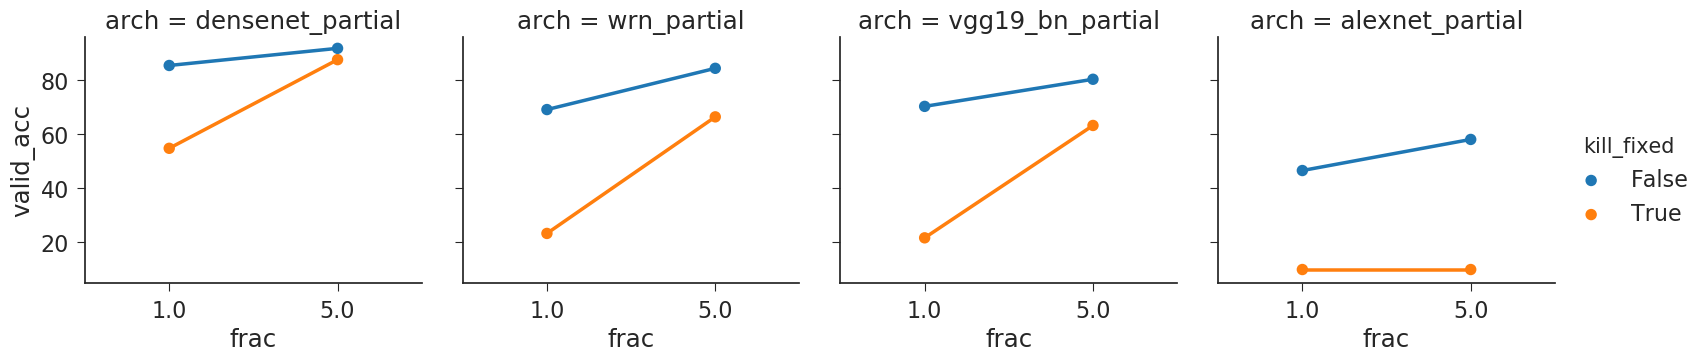

In [294]:
sns.factorplot(data=df[df.dataset=='cifar10'],x='frac',y='valid_acc',col='arch',hue='kill_fixed')


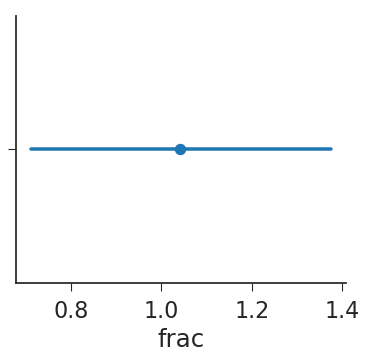

In [278]:
sns.factorplot(data=df,x='frac',y='valid_acc')
df=df[df['frac']>=1]
df.arch=[x.replace('_partial','') for x in list(df.arch)]
df.frac=df.frac.apply(int)

#ns.factorplot(data=df,x='frac',y='valid_acc')

TypeError: cannot label index with a null key

In [27]:
df.valid_acc.max()

96.1

In [28]:
df = pd.DataFrame(ddd)
df = df[((df.frac==1) ) & (df.dataset=='cifar100')].sort_values('arch')
df['z']=100*(df.active_params/df.total_params)
df

,active_params,all_accs,arch,dataset,dim_slice,fast_schedule,frac,kill_fixed,learn_bn,optimizer,total_params,train_only,valid_acc,z
86,35156,0 1.32 1 1.88 2 3.60 3 ...,alexnet_partial,cifar100,0,False,1.0,False,True,sgd,2495396,train_all,17.20,1.408835
87,35156,0 1.0 1 1.0 2 1.0 3 1.0 4 ...,alexnet_partial,cifar100,0,False,1.0,True,True,sgd,2495396,train_all,1.00,1.408835
80,88399,0 14.61 1 20.90 2 24.93 3 ...,densenet_partial,cifar100,0,False,1.0,False,True,sgd,800032,train_all,59.73,11.049433
81,88399,0 4.44 1 6.96 2 8.47 3 ...,densenet_partial,cifar100,0,False,1.0,True,True,sgd,800032,train_all,19.24,11.049433
84,107279,0 10.92 1 14.18 2 15.89 3 ...,vgg19_bn_partial,cifar100,0,False,1.0,False,True,sgd,20086692,train_all,41.02,0.534080
85,107279,0 2.44 1 2.38 2 2.67 3 1.8...,vgg19_bn_partial,cifar100,0,False,1.0,True,True,sgd,20086692,train_all,3.44,0.534080
82,157599,0 3.75 1 5.75 2 5.26 3 ...,wrn_partial,cifar100,0,False,1.0,False,True,sgd,36536884,train_all,34.85,0.431342
83,157599,0 1.97 1 2.11 2 2.35 3 2.4...,wrn_partial,cifar100,0,False,1.0,True,True,sgd,36536884,train_all,3.43,0.431342


In [10]:
# plot performance vs fraction.

In [458]:
df = pd.DataFrame(ddd)
df_max=df.loc[df.groupby('arch')['valid_acc'].idxmax()].sort_values('valid_acc')

for a in df_max.arch:
    df.loc[df.arch==a].valid_acc/=df_max[df_max.arch==a].iloc[0].valid_acc

In [461]:
df.arch

0      densenet_partial
1      densenet_partial
2           wrn_partial
3           wrn_partial
4      vgg19_bn_partial
5      vgg19_bn_partial
6       alexnet_partial
7       alexnet_partial
8      densenet_partial
9      densenet_partial
10          wrn_partial
11          wrn_partial
12     vgg19_bn_partial
13     vgg19_bn_partial
14      alexnet_partial
15      alexnet_partial
16     densenet_partial
17     densenet_partial
18          wrn_partial
19          wrn_partial
20     vgg19_bn_partial
21     vgg19_bn_partial
22      alexnet_partial
23      alexnet_partial
24     densenet_partial
25     densenet_partial
26          wrn_partial
27          wrn_partial
28     vgg19_bn_partial
29     vgg19_bn_partial
             ...       
74          wrn_partial
75          wrn_partial
76     vgg19_bn_partial
77     vgg19_bn_partial
78      alexnet_partial
79      alexnet_partial
80     densenet_partial
81     densenet_partial
82          wrn_partial
83          wrn_partial
84     vgg19_bn_

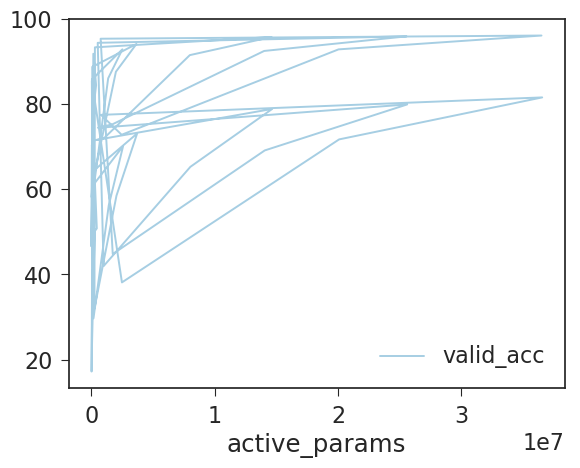

In [467]:
df[df.kill_fixed=.plot('active_params','valid_acc')

In [468]:
df[df.arch=='densenet_partial'].sort_values('valid_acc',ascending=False)

,active_params,all_accs,arch,dataset,dim_slice,fast_schedule,frac,kill_fixed,learn_bn,optimizer,total_params,train_only,valid_acc
64,769162,0 56.76 1 68.81 2 74.09 3 ...,densenet_partial,cifar10,0,False,-1.00,False,True,sgd,769162,train_all,95.35
49,532894,0 52.90 1 62.77 2 75.83 3 ...,densenet_partial,cifar10,0,False,0.70,True,True,sgd,769162,train_all,94.53
48,532894,0 60.78 1 68.81 2 73.80 3 ...,densenet_partial,cifar10,0,False,0.70,False,True,sgd,769162,train_all,94.39
32,305701,0 59.73 1 68.42 2 72.93 3 ...,densenet_partial,cifar10,0,False,0.40,False,True,sgd,769162,train_all,93.33
33,305701,0 52.36 1 65.78 2 72.86 3 ...,densenet_partial,cifar10,0,False,0.40,True,True,sgd,769162,train_all,92.46
88,177973,0 55.89 1 65.57 2 70.61 3 ...,densenet_partial,cifar10,0,False,5.00,False,True,sgd,769162,train_all,91.82
16,90196,0 55.78 1 62.21 2 65.64 3 ...,densenet_partial,cifar10,0,False,0.10,False,True,sgd,769162,train_all,88.73
89,177973,0 42.24 1 54.82 2 62.49 3 ...,densenet_partial,cifar10,0,False,5.00,True,True,sgd,769162,train_all,87.63
0,58453,0 48.82 1 53.77 2 57.99 3 ...,densenet_partial,cifar10,0,False,0.07,False,True,sgd,769162,train_all,85.76
72,57529,0 50.97 1 54.70 2 60.63 3 ...,densenet_partial,cifar10,0,False,1.00,False,True,sgd,769162,train_all,85.48


In [192]:
sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
df = pd.DataFrame(ddd)
#df[df.frac==-1]


#df.arch.apply(lambda x:x.replace('partial_',''))
#df.arch=


In [193]:
best_values = {}
best_values['a','b']=1
best_values


{('a', 'b'): 1}

In [194]:
df = pd.DataFrame(ddd)
df_max=df.loc[df.groupby('arch')['valid_acc'].idxmax()].sort_values('valid_acc')

for a in df_max.arch:
    df.loc[df.arch==a].valid_acc/=df_max[df_max.arch==a].iloc[0].valid_acc
archs = df.arch.unique()
datasets = df.dataset.unique()

best_values = {}

for D in datasets:
    for A in archs:
        break
        
    df1=df[(df.arch==A) & (df.dataset==dataset)]
    df1.sort_values('valid_acc',ascending=False)
  


In [130]:
df_max[df_max.arch==a].valid_acc

65    96.1
Name: valid_acc, dtype: float64

In [195]:
df = pd.DataFrame(ddd)
df.loc[df.arch==a,'valid_acc']/=df_max[df_max.arch==a].iloc[0].valid_acc/100



In [196]:
df = pd.DataFrame(ddd)
df_max=df.loc[df.groupby('arch')['valid_acc'].idxmax()].sort_values('valid_acc')
for a in df_max.arch:
    df.loc[df.arch==a,'valid_acc']/=df_max[df_max.arch==a].iloc[0].valid_acc/100

#df[df.arch==a].valid_acc


In [197]:
df_max

,active_params,all_accs,arch,dataset,dim_slice,fast_schedule,frac,kill_fixed,learn_bn,optimizer,total_params,train_only,valid_acc
54,1727890,0 38.16 1 47.37 2 48.71 3 ...,alexnet_partial,cifar10,0,False,0.7,False,True,sgd,2472266,train_all,75.26
66,20040522,0 11.10 1 11.65 2 25.81 3 ...,vgg19_bn_partial,cifar10,0,False,-1.0,False,True,sgd,20040522,train_all,92.85
64,769162,0 56.76 1 68.81 2 74.09 3 ...,densenet_partial,cifar10,0,False,-1.0,False,True,sgd,769162,train_all,95.35
65,36479194,0 52.08 1 60.38 2 62.54 3 ...,wrn_partial,cifar10,0,False,-1.0,False,True,sgd,36479194,train_all,96.10


In [141]:
df_max[['arch','dataset','valid_acc']]

,arch,dataset,valid_acc
62,alexnet_partial,cifar100,44.79
70,vgg19_bn_partial,cifar100,71.71
54,alexnet_partial,cifar10,75.26
68,densenet_partial,cifar100,77.47
69,wrn_partial,cifar100,81.57
66,vgg19_bn_partial,cifar10,92.85
64,densenet_partial,cifar10,95.35
65,wrn_partial,cifar10,96.10


In [173]:
df = pd.DataFrame(ddd)

df_max=df.loc[df.groupby(['arch','dataset'])['valid_acc'].idxmax()].sort_values('valid_acc')
df_max
df_max[ (df_max.dataset==d)].valid_acc/100

54    0.7526
66    0.9285
64    0.9535
65    0.9610
Name: valid_acc, dtype: float64

In [180]:
x

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745)]

# Compare fractional number of params.

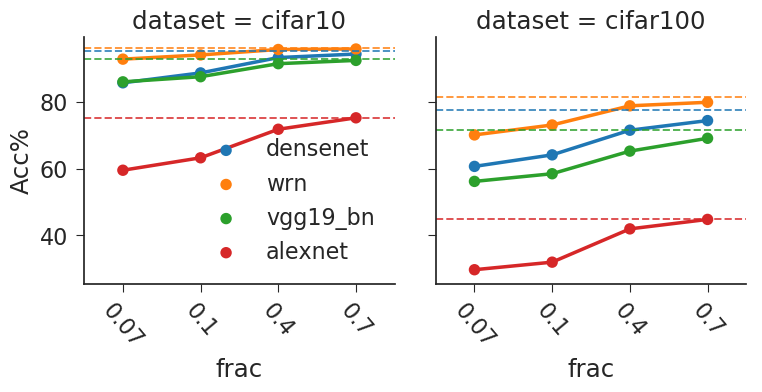

In [542]:
df = pd.DataFrame(ddd)
sns.reset_defaults()
df_max=df.loc[df.groupby(['arch','dataset'])['valid_acc'].idxmax()].sort_values('valid_acc')
df_max.arch=[x.replace('_partial','') for x in list(df_max.arch)]

#for a in df_max.arch.unique():
#    for d in df_max.dataset.unique():
#        df.loc[(df.arch==a) & (df.dataset==d),'valid_acc']/=df_max[(df_max.arch==a) & (df_max.dataset==d)].iloc[0].valid_acc/100

#archs = df.arch.unique()

sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
#df = pd.DataFrame(ddd)
#df['frac'] = df['frac'].round(2)
#df=df[df.arch!='vgg19_partial']
df=df[df.optimizer=='sgd']
df.arch=[x.replace('_partial','') for x in list(df.arch)]
#df['abs_filters']=df.frac>=1
df.sort_values('frac')
if LIMIT_EPOCHS != 1:    
    df = df[df.learn_bn==True]
    theHue = 'kill_fixed'
else:
    #df = df[df.frac>0]        
    df = df[df.kill_fixed==False]
    theHue = 'learn_bn'        
df = df[df.kill_fixed==False]
df = df[df.frac>0]      
df = df[df.frac<1]   
palette = sns.color_palette()
df=df.rename(columns={'valid_acc':'Acc%'})
g=sns.factorplot(data=df,x='frac',y='Acc%',col='dataset',hue='arch',legend=False,
                width=1)
g.fig.get_axes()[0].legend(loc='lower right')
g.set_xticklabels(rotation=-50)
axes_ = list(g.axes[0])

for i,q in enumerate(df.arch.unique()):
    val=df_max[(df_max.arch==q) & (df_max.dataset=='cifar10')].iloc[0].valid_acc
    axes_[0].plot([ZZ0,ZZ],2*[val],linestyle='--',color=palette[i], alpha=theAlpha)
    val=df_max[(df_max.arch==q) & (df_max.dataset=='cifar100')].iloc[0].valid_acc
    axes_[1].plot([ZZ0,ZZ],2*[val],linestyle='--',color=palette[i], alpha=theAlpha)
theAlpha=.8
ZZ = 5
ZZ0 = -.5
baseDir = '/home/amir/Dropbox/publications/2018/BMVC/BMVC2018_sty_review/figures/'
from os.path import join as opj
savefig(opj(baseDir,'frac_vs_perf_full_run-crop.pdf'),bbox_inches='tight')

In [543]:
baseDir

'/home/amir/Dropbox/publications/2018/BMVC/BMVC2018_sty_review/figures/'

In [ ]:
# Compare zeroed-out vs not zeroed out.

In [ ]:
df = pd.DataFrame(ddd)
df_max=df.loc[df.groupby(['arch','dataset'])['valid_acc'].idxmax()].sort_values('valid_acc')
df_max.arch=[x.replace('_partial','') for x in list(df_max.arch)]

#for a in df_max.arch.unique():
#    for d in df_max.dataset.unique():
#        df.loc[(df.arch==a) & (df.dataset==d),'valid_acc']/=df_max[(df_max.arch==a) & (df_max.dataset==d)].iloc[0].valid_acc/100
#archs = df.arch.unique()
sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
#df = pd.DataFrame(ddd)
#df['frac'] = df['frac'].round(2)
#df=df[df.arch!='vgg19_partial']
df=df[df.optimizer=='sgd']
df.arch=[x.replace('_partial','') for x in list(df.arch)]
#df['abs_filters']=df.frac>=1
df.sort_values('frac')
df = df[df.frac>0]      
df = df[df.frac<1]   
palette = sns.color_palette()
df=df.rename(columns={'valid_acc':'Acc%'})


#43
def foo(x):
    if x:
        return ''
    else:
        return '+'
#df = pd.DataFrame(ddd)
#df = df[(df.frac>=1) ]
#df.frac=df.frac.apply(int)
#df.at[df.frac<0,'frac']=''
#df=df[['arch','active_params','valid_acc','dataset','frac','kill_fixed','total_params']]
#df=df[df.dataset=='cifar10']
#df=df[['arch','valid_acc','frac','kill_fixed','dataset']]
#df.arch=df.arch+df.kill_fixed.apply(foo) 

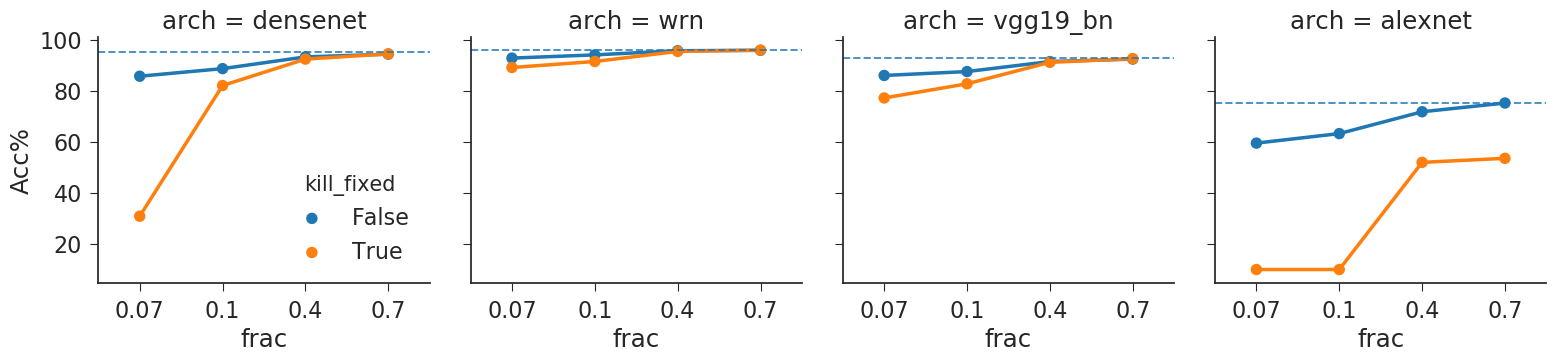

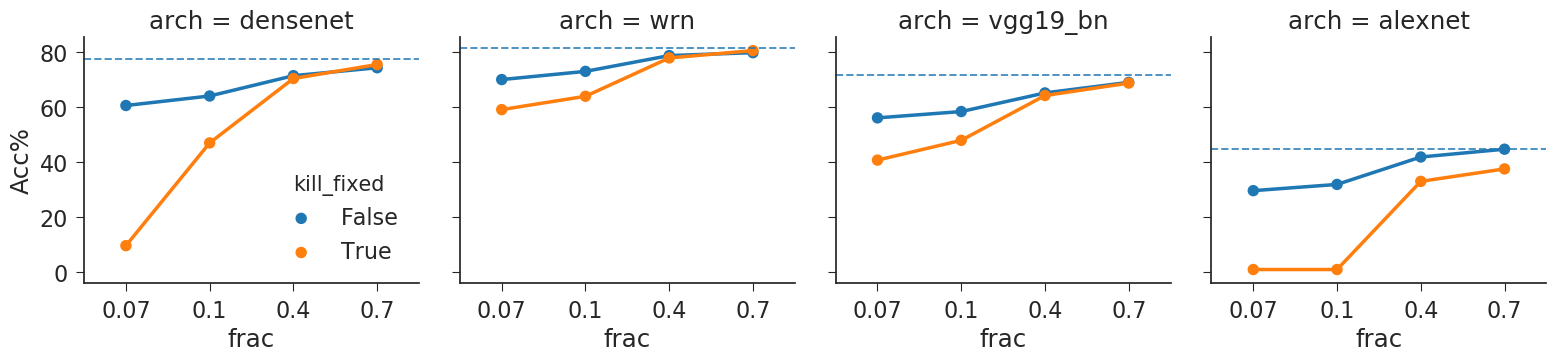

In [590]:
g=sns.factorplot(data=df[df.dataset=='cifar10'],x='frac',y='Acc%',col='arch',hue='kill_fixed',legend_out=False)
axes_ = list(g.axes[0])
toSave=True
for i,q in enumerate(df.arch.unique()):
        val=df_max[(df_max.arch==q) & (df_max.dataset=='cifar10')].iloc[0].valid_acc
        axes_[i].plot([ZZ0,ZZ],2*[val],linestyle='--',color=palette[0], alpha=theAlpha)
if toSave: savefig('/home/amir/Dropbox/publications/2018/BMVC/BMVC2018_sty_review/\
figures/cifar10_frac_vs_perf_10_epochs-crop.pdf',bbox_inches='tight')
g=sns.factorplot(data=df[df.dataset=='cifar100'],x='frac',y='Acc%',col='arch',hue='kill_fixed',legend_out=False)
axes_ = list(g.axes[0])
for i,q in enumerate(df.arch.unique()):
        val=df_max[(df_max.arch==q) & (df_max.dataset=='cifar100')].iloc[0].valid_acc
        axes_[i].plot([ZZ0,ZZ],2*[val],linestyle='--',color=palette[0], alpha=theAlpha)
if toSave:  savefig('/home/amir/Dropbox/publications/2018/BMVC/BMVC2018_sty_review\
/figures/cifar100_frac_vs_perf_10_epochs-crop.pdf',bbox_inches='tight')

IndexError: list index out of range

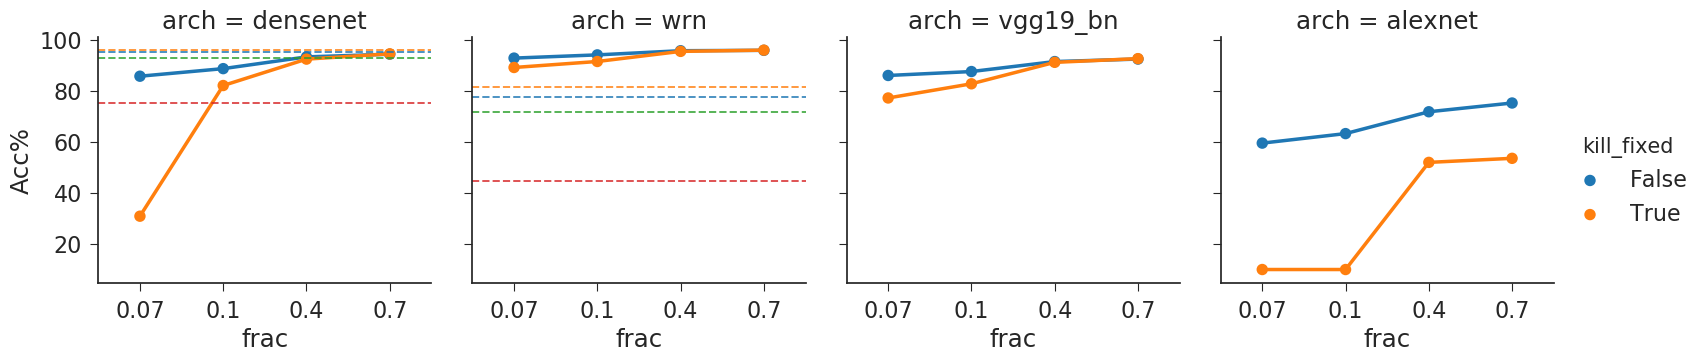

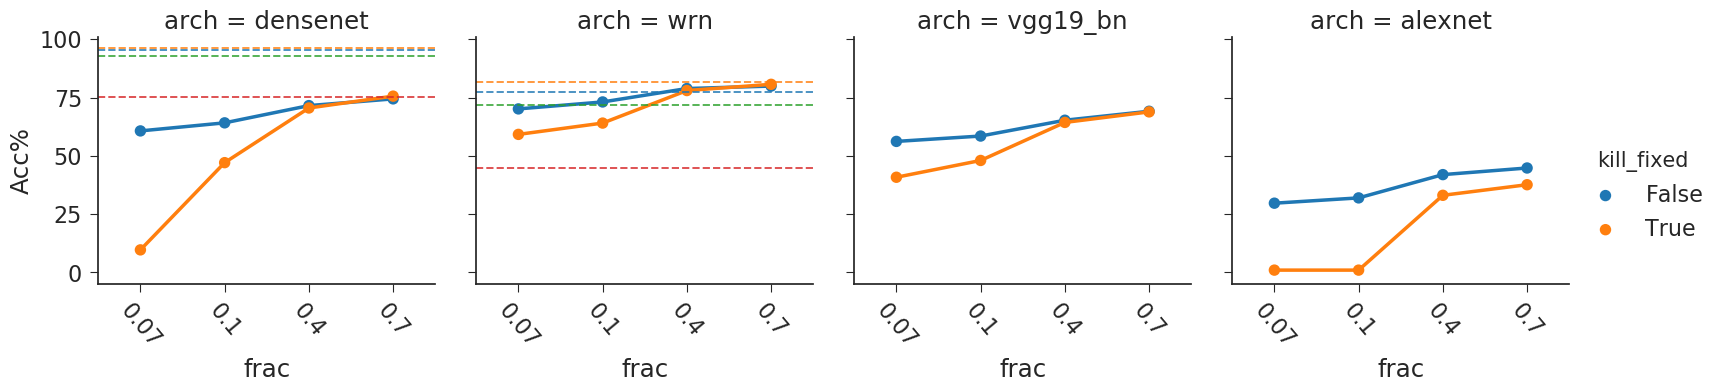

In [241]:
g=sns.factorplot(data=df[df.dataset=='cifar100'],x='frac',y='Acc%',col='arch',hue='kill_fixed',legend_out=True)

g.set_xticklabels(rotation=-50)
axes_ = list(g.axes[0])
if True:
    for i,q in enumerate(df.arch.unique()):
        val=df_max[(df_max.arch==q) & (df_max.dataset=='cifar10')].iloc[0].valid_acc
        axes_[0].plot([ZZ0,ZZ],2*[val],linestyle='--',color=palette[i], alpha=theAlpha)
        val=df_max[(df_max.arch==q) & (df_max.dataset=='cifar100')].iloc[0].valid_acc
        axes_[1].plot([ZZ0,ZZ],2*[val],linestyle='--',color=palette[i], alpha=theAlpha)
theAlpha=.8
ZZ = 5
ZZ0 = -.5

In [209]:
df_max[(df_max.arch==q) & (df_max.dataset=='cifar10')]

,active_params,all_accs,arch,dataset,dim_slice,fast_schedule,frac,kill_fixed,learn_bn,optimizer,total_params,train_only,valid_acc


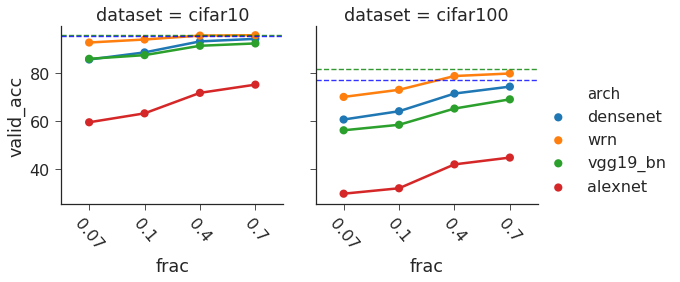

In [33]:
axes_[0].plot([ZZ0,ZZ],2*[96.2],color='g',linestyle='--',alpha=theAlpha)
axes_[0].plot([ZZ0,ZZ],2*[100-4.54],color='blue',linestyle='--',alpha=theAlpha)
axes_[1].plot([ZZ0,ZZ],2*[100- 18.14],color='g',linestyle='--',alpha=theAlpha)
axes_[1].plot([ZZ0,ZZ],2*[100-22.88],color='blue',linestyle='--',alpha=theAlpha) #

#axes_[1].plot([-1,9],2*[96.2],color='g',linestyle='--')
#axes_[1].plot([-1,9],2*[100-4.54],color='r',linestyle='--')
#suptitle(z.upper(),y=1)    
#for ax in list(g.axes[0]):
#    ax.add_patch(patches.Rectangle(xy=(6, 0), width=4, height=100,alpha=.1,color='k'))
    #df = pd.DataFrame(ddd)
    #z = df[(df.frac==-1) &(df.train_only=='train_all') & (df.learn_bn==True) & (df.kill_fixed==False) &\
    #      (df.dataset==z)]
    #ax.plot([-1,9],2*[zs[iz]],color='k',linestyle='--')
    #iz+=1
       
#savefig('/home/amir/Dropbox/publications/2018/icml2018_style/figures/frac_vs_perf_full_run.pdf')

(90, 100)

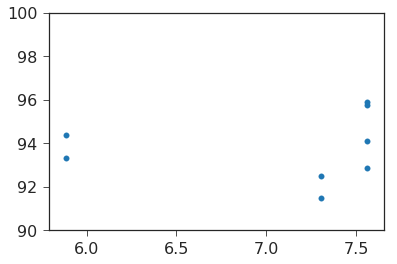

In [16]:
df1 = df[df.dataset=='cifar10']
scatter(log10(df1.total_params),df1.valid_acc)
ylim([90,100])

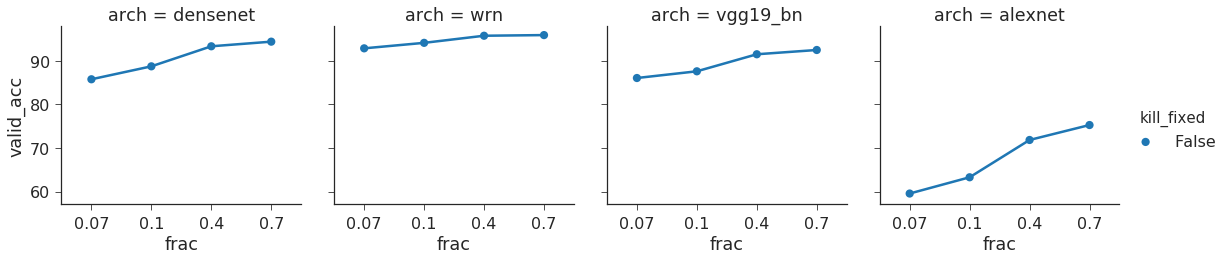

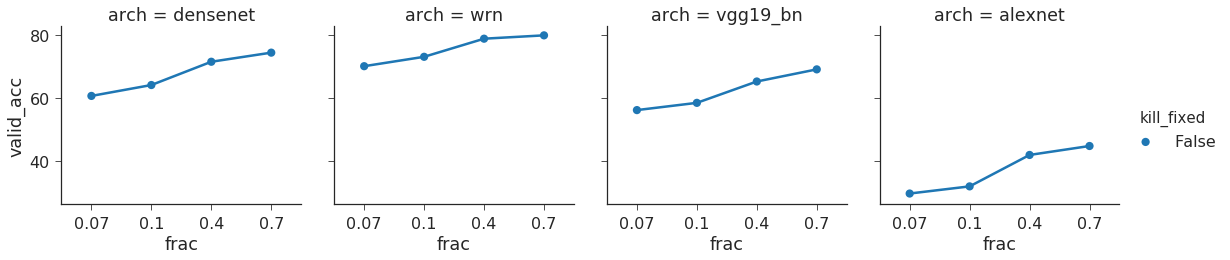

In [17]:
sns.factorplot(data=df[df.dataset=='cifar10'],x='frac',y='valid_acc',col='arch',hue='kill_fixed')
sns.factorplot(data=df[df.dataset=='cifar100'],x='frac',y='valid_acc',col='arch',hue='kill_fixed')

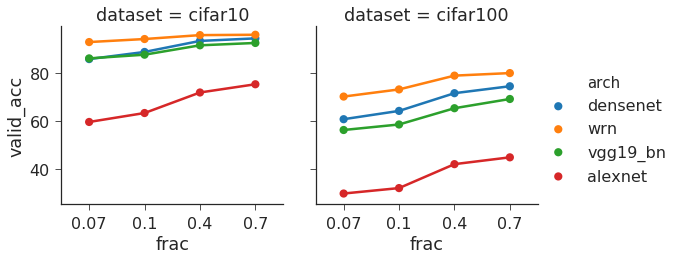

In [18]:
g=sns.factorplot(data=df,x='frac',y='valid_acc',col='dataset',hue='arch',legend_out=True)

In [116]:
# train imagenet.
# (wideresnet)
python cifar.py -a wideresnet --dataset small_imagenet --epochs 80 --schedule 41 71 --gamma 0.1 --weight-decay 1e-4 -c /home/amir/checkpoints/small_imagenet/wrn_full_F --train-batch 128

SyntaxError: invalid syntax (<ipython-input-116-a9321b7c214e>, line 3)

In [ ]:
python cifar.py -a wideresnet_partial --part .1 --dataset small_imagenet --epochs 80 --schedule 41 71 --gamma 0.1 --weight-decay 1e-4 -c /home/amir/checkpoints/small_imagenet/wrn_partial_0.1 --train-batch 128
python cifar.py -a wideresnet_partial --part .1 --dataset small_imagenet --epochs 80 --schedule 41 71 --gamma 0.1 --weight-decay 1e-4 -c /home/amir/checkpoints/small_imagenet/wrn_partial_0.1_kill --train-batch 128 --zero-fixed-part True
python cifar.py -a wideresnet_partial --part .7 --dataset small_imagenet --epochs 80 --schedule 41 71 --gamma 0.1 --weight-decay 1e-4 -c /home/amir/checkpoints/small_imagenet/wrn_partial_0.7 --train-batch 128 --zero-fixed-part False
python cifar.py -a wideresnet_partial --part .7 --dataset small_imagenet --epochs 80 --schedule 41 71 --gamma 0.1 --weight-decay 1e-4 -c /home/amir/checkpoints/small_imagenet/wrn_partial_0.7_kill --train-batch 128 --zero-fixed-part True
python cifar.py -a wideresnet_partial --part .4 --dataset small_imagenet --epochs 80 --schedule 41 71 --gamma 0.1 --weight-decay 1e-4 -c /home/amir/checkpoints/small_imagenet/wrn_partial_0.4 --train-batch 128
python cifar.py -a wideresnet_partial --part .4 --dataset small_imagenet --epochs 80 --schedule 41 71 --gamma 0.1 --weight-decay 1e-4 -c /home/amir/checkpoints/small_imagenet/wrn_partial_0.4_kill --train-batch 128 --zero-fixed-part True



In [19]:

print('0.1')

a = torch.load('/home/amir/checkpoints/small_imagenet/wrn_partial_0.1_kill/model_best.pth.tar'); # 0.1/kill: 18.9
print a['best_acc']
a = torch.load('/home/amir/checkpoints/small_imagenet/wrn_partial_0.1/model_best.pth.tar'); # 0.1/kill: 18.9
print a['best_acc']
print('0.4')

a = torch.load('/home/amir/checkpoints/small_imagenet/wrn_partial_0.4_kill//model_best.pth.tar'); # partial 0.4 : 53.18
print a['best_acc']
a = torch.load('/home/amir/checkpoints/small_imagenet/wrn_partial_0.4/model_best.pth.tar'); # partial 0.4 : 53.18
print a['best_acc']

print('0.7')
a = torch.load('/home/amir/checkpoints/small_imagenet/wrn_partial_0.7_kill/model_best.pth.tar'); # 0.7/kill: 34.75
print a['best_acc']
a = torch.load('/home/amir/checkpoints/small_imagenet/wrn_partial_0.7/model_best.pth.tar'); # 0.7 34.75
print a['best_acc']

print('full')
a = torch.load('/home/amir/checkpoints/small_imagenet/wrn_full_F/model_best.pth.tar') # full : 63.906
print a['best_acc']

0.1
18.1979591837
34.3755102041
0.4
44.2448979592
53.1857142857
0.7
59.393877551
60.4408163265
full
63.906122449


44.2448979592
53.1857142857


18.1979591837
34.3755102041


53.0040816327
54.0102040816


Populating the interactive namespace from numpy and matplotlib


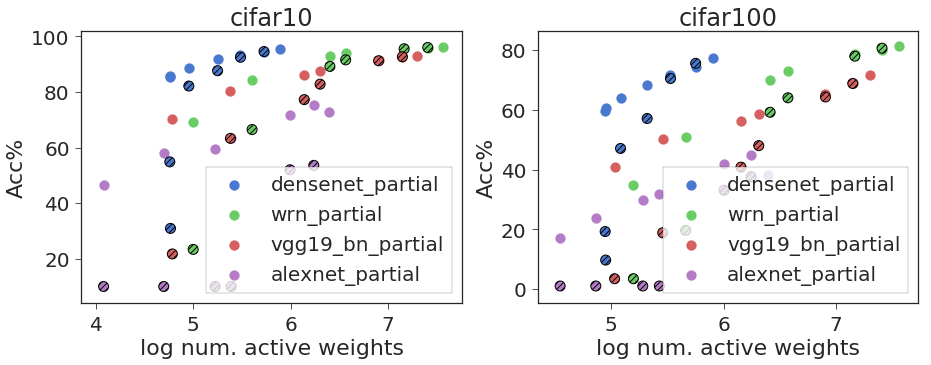

In [488]:
close()
%pylab inline
import seaborn as sns
sns.set_context('paper',font_scale=2.5)
sns.set_style('ticks')
df = pd.DataFrame(ddd)
if False:
    kf = df.kill_fixed
    aa = df.arch
    z = []
    for a,b in zip(aa,kf):
        if b:
            z.append(a+'_zero')
        else:
            z.append(a+'_fix')
    df['arch'] = z
ss=100
figure(figsize=(15,5))
mmmm=1
nnnn=2
colors=sns.color_palette('muted',len(archs))
for ii,zz in enumerate(['cifar10','cifar100']):
    
    subplot(mmmm,nnnn,ii+1);title(zz)
    for i,z in enumerate(archs):        
        df1=df[df.dataset==zz]
        df1 = df1[df1.arch==z]
        p = False;            
        df1 = df1[df1.kill_fixed==p]
        kwargs = dict(x=log10(df1.active_params), y=df1['valid_acc'], label=z, color=colors[i],s=ss)#, marker=theMarker)
        scatter(**kwargs)
        xlabel('log num. active weights')
        ylabel('Acc%')
    if True:#ii == 1:
        leg=legend(loc='lower right',frameon=True,fancybox=False)
        leg.get_frame().set_edgecolor('k')
        
        
#font = {'size'   : 50}

#matplotlib.rc('font', **font)
        
if True:
    for ii,zz in enumerate(['cifar10','cifar100']):

        subplot(mmmm,nnnn,ii+1);title(zz)
        for i,z in enumerate(archs):        
            df1=df[df.dataset==zz]
            df1 = df1[df1.arch==z]

            #plot(range(10,range(10)))
            p = True;
            #for p in [False,True]:
            df1 = df1[df1.kill_fixed==p]
            
            #theMarker = '*'
            #marker=theMarker
            kwargs = dict(x=log10(df1.active_params), y=df1['valid_acc'], color=colors[i],s=ss,edgecolor='k',linewidth=1, hatch='////')
            scatter(**kwargs)
            matplotlib.rcParams.update({'font.size': 22})
            
savefig(os.path.join(baseDir,'perf_vs_params2.pdf'),bbox_inches='tight')

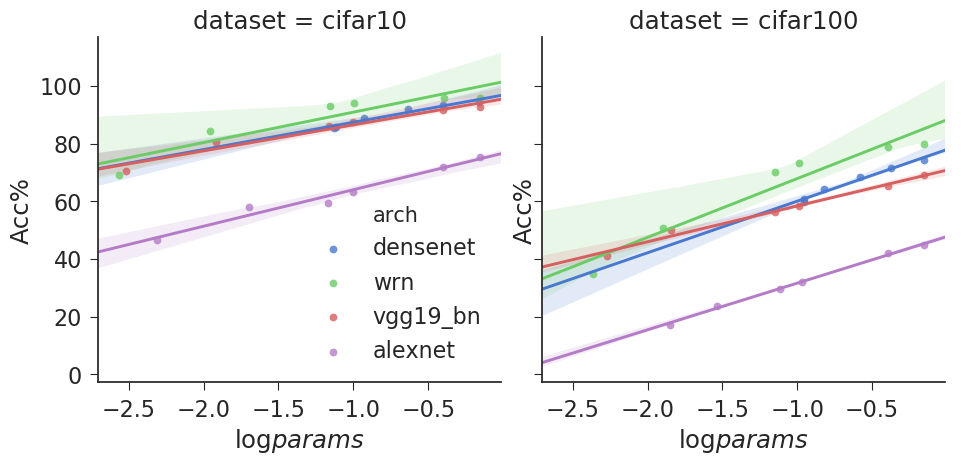

In [592]:
df = pd.DataFrame(ddd)

colors=sns.color_palette('muted',len(archs))
sns.set_palette(colors)
df = df[df.train_only=='train_all']
df = df[df.learn_bn==True]
df = df[df.frac>0]
df.active_params/=df.total_params
df = df[df.kill_fixed==False]
df = df[df.kill_fixed==False]
df = df[df.arch!='vgg19_partial']
df.arch=[x.replace('_partial','') for x in list(df.arch)]

df.active_params = log10(df.active_params)#**.5
#df.valid_acc = df.valid_acc.apply(lambda x: log10(x)) #= log10(df.valid_acc)
#df = df[df.arch!='vgg19_bn_partial']
#df = df[df.arch!='alexnet_partial']
g = sns.lmplot(data=df,x='active_params',y='valid_acc',hue='arch',col='dataset',logx=False,legend_out=False)
for gg in g.axes[0]:
    gg.set_xlabel('$\log{params}$')
    gg.set_ylabel('Acc%')   
   
savefig(os.path.join(baseDir,'perf_vs_params_lines2.pdf'),bbox_inches='tight')